# QCoDeS Example with with Keithley 2600

In [22]:
import qcodes as qc

from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.sqlite.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment

In [2]:
# Create a station to hold all the instruments

station = qc.Station()

# instantiate the Keithley and add it to the station

keith = Keithley_2600('keithley', 'USB0::0x05E6::0x2614::4305420::INSTR')
station.add_component(keith)

Connected to: Keithley Instruments Inc. 2614B (serial:4305420, firmware:3.2.2) in 0.10s


'keithley'

The Keithley 2600 has two channels, here called `smua` and `smub` in agreement with the instrument manual.

The two channels are basically two separate instruments with different integration times (`nplc`), operation modes (`mode`) etc.

In [3]:
# Get an overview of the settings
#
# You will notice that the two channels have identical parameters but
# potentially different values for them
#
keith.print_readable_snapshot()

keithley:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': 'Keithley Instruments Inc.', 'model': '2614B', '...
display_settext :	None 
timeout         :	5 (s)
keithley_smua:
	parameter                  value
--------------------------------------------------------------------------------
curr                        :	7.1526e-08 (A)
fastsweep                   :	Not available 
limiti                      :	0.1 (A)
limitv                      :	20 (V)
linefreq                    :	50 (Hz)
measure_autorange_i_enabled :	0 
measure_autorange_v_enabled :	1 
measurerange_i              :	0.1 (A)
measurerange_v              :	20 (V)
mode                        :	voltage 
nplc                        :	0.05 
output                      :	1 
res                         :	5.4138e+06 (Ohm)
source_autorange_i_enabled  :	1 
source_autorange_v_enabled  :	0 
sourcerange_i               :	1e-07 (A)
sourcerange_v          

## Basic operation

Each channel operates in either `voltage` or `current` mode. The mode controls the _source_ behaviour of the instrument, i.e. `voltage` mode corresponds to an amp-meter (voltage source, current meter) and vice versa.

In [4]:
# Let's set up a single-shot current measurement
# on channel a

keith.smua.mode('voltage')
keith.smua.nplc(0.05)  # 0.05 Power Line Cycles per measurement. At 50 Hz, this corresponds to 1 ms
keith.smua.sourcerange_v(20) 
keith.smua.measurerange_i(0.1)
#
keith.smua.volt(1)  # set the source to output 1 V
keith.smua.output('on')  # turn output on
curr = keith.smua.curr()
keith.smua.output('off')

print('Measured one current value: {} A'.format(curr))

Measured one current value: 6.55651e-07 A


## Fast IV curves

Onboard the Keithley 2600 sits a small computer that can interpret `Lua` scripts. This can be used to make fast IV-curves and is supported by the QCoDeS driver.

In [5]:
# Let's make a fast IV curve by sweeping the voltage from 1 V to 2 V in 500 steps
# (when making this notebook, nothing was connected to the instrument, so we just measure noise)

In [6]:
# This function performs the fast sweep and returns a QCoDeS DataSet
data = keith.smua.doFastSweep(1, 2, 500, mode='IV')

DataSet:
   location = 'data/2019-09-16/#001_{name}_14-48-19'
   <Type>   | <array_id>              | <array.name> | <array.shape>
   Measured | keithley_smua_fastsweep | iv_sweep     | (500,)
acquired at 2019-09-16 14:48:20


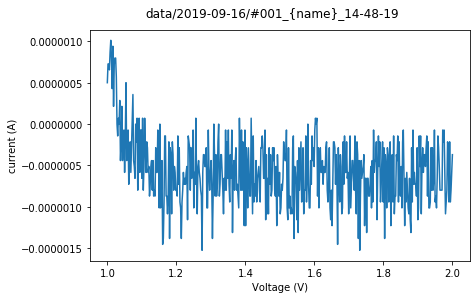

In [7]:
# The DataSet may be plotted
plot = qc.MatPlot()
plot.add(data.arrays['keithley_smua_fastsweep'])

In [8]:
# Finally, tear down the instrument
keith.close()

## Time Trace

We can measure current or voltage as a function of time, as well. Let us consider the case in which we would like to have the time trace of current. We, then, first set our trace mode accordingly

In [13]:
keith.smua.timetrace_mode('current')

The latter should not be confused with the channel mode. Next, we register our parameter

In [14]:
timemeas = qc.Measurement()
timemeas.register_parameter(keith.smua.timetrace)

The total time interval is returned by `time_axis` method in accordance with the integration time `dt` and the total number of points `npts` with default values of 1 ms and 500, respectively. Specifically, the time trace will be obtained for an interval of `[0, dt*npts]`. Thus, for the default values, we shall have a time trace of current for `500 ms` calculated at 500 steps.

In [15]:
keith.smua.timetrace_dt()

0.002

In [16]:
keith.smua.timetrace_npts()

600

Starting experimental run with id: 3


([<matplotlib.axes._subplots.AxesSubplot at 0x290f56be320>], [None])

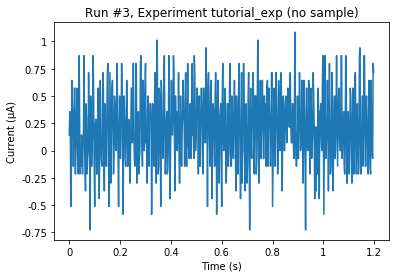

In [17]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

with timemeas.run() as datasaver:
    
    somenumbers = keith.smua.timetrace.get()
    datasaver.add_result((keith.smua.timetrace, somenumbers), 
                         (keith.smua.time_axis, keith.smua.time_axis.get()))
    
data = datasaver.dataset
plot_dataset(data)

Let us get another trace for 2ms integration time with 600 steps

In [18]:
keith.smua.timetrace_dt(0.002)

In [19]:
keith.smua.timetrace_npts(600)

Starting experimental run with id: 4


([<matplotlib.axes._subplots.AxesSubplot at 0x290f672ab00>], [None])

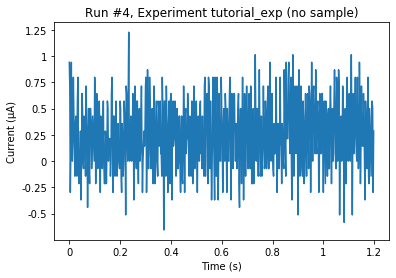

In [20]:
with timemeas.run() as datasaver:
    
    somenumbers = keith.smua.timetrace.get()
    datasaver.add_result((keith.smua.timetrace, somenumbers), 
                         (keith.smua.time_axis, keith.smua.time_axis.get()))
    
data = datasaver.dataset
plot_dataset(data)

Similarly, we can get the time trace for voltage via changing the mode

In [21]:
keith.smua.timetrace_mode('voltage')

In this case, one should re-register the time trace parameter to have the correct units and labels. Finally, we note that ``keith.smua.timetrace`` is a ``ParameterWithSetpoints`` and hence ``expand_setpoints_helper`` can be used in the ``add_result`` call as well.